Data can be obtained by using the following command on either lyon or nancy site :

# Tools

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)

from tools import normalize_dataframe,clean_dataframe, get_g5k_password
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from statistics import median, mean
import random
import json
import numpy as np

In [3]:
def get_monitoring_power(hostname, startTime, basename, fullname, host=None):
    fullpath= '%s_power/%s_%s_%s' % (basename, hostname, fullname, startTime)
    with open(fullpath) as file_id:
        data = json.loads(file_id.read())
        
    if host is None:
        host = hostname.split('.')[0]
    data = [ (t,p) for (h, t, p) in data if h == host]

    return data[0]

def get_monitoring_mojitos(hostname, startTime, basename, fullname, host=None):
    fullpath= '%s_mojitos/%s_%s_%s' % (basename, hostname, fullname, startTime)
    data = clean_dataframe(pd.read_csv(fullpath,sep=' '))
    if '0' in data:
        data=data.drop('0', axis=1)
    if '1' in data:
        data=data.drop('1', axis=1)
    return data

In [4]:
def read_experiment(basename, only_complete=False, keep_only=None):
    knowledge = pd.read_csv(basename, sep=' ')
    if only_complete:
        nb_lev = len(knowledge.fmax.unique())
        nb_expe = len(knowledge) // nb_lev
        knowledge = knowledge[0:nb_expe*nb_lev]
        ids_expe = [[i]*nb_lev for i in range(nb_expe)]

        knowledge['expe'] = [j for i in ids_expe for j in i]
    
    knowledge['basename'] = basename
    try:
        knowledge['energy'] = knowledge.apply(lambda row: mean(get_monitoring_power(row.hostname, row.startTime, row.basename, row.fullname )[1])*row.duration, axis=1)
        knowledge['etp']=knowledge.apply(lambda row: row.duration*row.energy, axis=1)
    except: # no energy monitoring associated
        pass
    
    try:
        mojitos_data = [get_monitoring_mojitos(row.hostname, row.startTime, row.basename, row.fullname) for index, row in knowledge.iterrows()]
    except: # no monitoring associated
        mojitos_data = []
    return knowledge, mojitos_data

In [5]:
#ben = {'bt-', 'sp-'}
#knowledge[knowledge['fullname'].str[:3].isin(ben)]

In [6]:
def show_heatmap(knowledge, x='fmax',y='fullname', metric='duration'):
    optimals=knowledge.groupby([x,y]).mean().groupby(y)
    optimals=optimals[metric]
    optimals=optimals.apply(list).apply(pd.Series)
    optimals.columns=knowledge[x].unique()
    optimals.style.background_gradient(cmap='Reds', axis=1)
    optimals =optimals.style.background_gradient(cmap='Reds', axis=1)
    return optimals

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets

# Read dataset

In [8]:
# Experiment with several types of benchmarks and 2 frequencies
#basename='features_grisou-51.nancy.grid5000.fr_1587061692'

# several types of bench and all frequencies
#basename = 'features_2ndstep_grisou-13.nancy.grid5000.fr_1587201761'
basename = 'features_grisou-13.nancy.grid5000.fr_1587256200'


In [9]:
knowledge, mojitos_data = read_experiment(basename, only_complete=True)

In [10]:
knowledge.head()

hostname fullname  nproc  duration   startTime  \
0  grisou-13.nancy.grid5000.fr  lu-C-64     64     33.83  1587256262   
1  grisou-13.nancy.grid5000.fr  lu-C-64     64     31.80  1587256311   
2  grisou-13.nancy.grid5000.fr  lu-C-64     64     30.29  1587256358   
3  grisou-13.nancy.grid5000.fr  lu-C-64     64     30.77  1587256403   
4  grisou-13.nancy.grid5000.fr  lu-C-64     64     27.69  1587256448   

      endTime     fmin     fmax  \
0  1587256298  1200000  1200000   
1  1587256345  1200000  1300000   
2  1587256390  1200000  1400000   
3  1587256435  1200000  1500000   
4  1587256478  1200000  1600000   

                                            hostlist  expe  \
0  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
1  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
2  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
3  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
4  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   

                                          basename       energy            etp  
0  features_grisou-13.nancy.grid5000.fr_1587256200  5287.816944  178886.847231  
1  features_grisou-13.nancy.grid5000.fr_1587256200  5096.672727  162074.192727  
2  features_grisou-13.nancy.grid5000.fr_1587256200  4879.621290  147803.728884  
3  features_grisou-13.nancy.grid5000.fr_1587256200  5058.780313  155658.670216  
4  features_grisou-13.nancy.grid5000.fr_1587256200  4586.387000  126997.056030

In [12]:
knowledge['uniqueName'] = knowledge.apply(lambda row: '%s_%s' %(row.fullname, row.nproc), axis=1)

In [13]:
optimals=knowledge.groupby(['uniqueName', 'fmax']).mean().groupby('uniqueName')
optimals=optimals['energy']
optimals=optimals.apply(list).apply(pd.Series)
optimals.columns=knowledge.fmax.unique()
optimals.style.background_gradient(cmap='Reds', axis=1)

In [10]:
mojitos_data[0].columns

Index(['cpu_migrations', 'cache_misses', 'cache_dtlb', 'cache_result_access',
       'cpu_clock', 'page_faults_maj', 'dummy', 'task_clock', 'cpu_cycles',
       'bpf_output', 'context_switches', 'emulation_faults', 'instructions',
       'bus_cycles', 'branch_instructions', 'cache_l1d', 'cache_op_read',
       'cache_op_prefetch', 'page_faults', 'cache_node', 'cache_bpu',
       'cache_references', 'branch_misses', 'cache_ll', 'alignment_faults',
       'cache_itlb', 'ref_cpu_cycles', 'page_faults_min', 'rxp', 'rxb', 'txp',
       'txb', 'package-00', 'dram0', 'package-11', 'dram1', 'user', 'nice',
       'system', 'idle', 'iowait', 'irq', 'softirq', 'steal', 'guest',
       'guest_nice'],
      dtype='object')

# Reduce number of monitored values

## PCA : without knowledge on the metrics

In [11]:
dataset = pd.concat(mojitos_data, ignore_index=True)

### Tools

In [2]:
def get_unused_features(dataset, debug=False, threshold_pca=1e-5):
    # Create a PCA that will retain 90% of the variance
    pca = PCA(n_components=.9, svd_solver = 'full', whiten=True)
    X = StandardScaler().fit_transform(dataset)
    X_pca = pca.fit_transform(X)

    # Returs the vector of the base un function of the input features
    rho = pd.DataFrame(pca.components_,columns=dataset.columns)
    
    # Sums the absolute contribution of each feature to each vector weighted by the
    # importance of the vector
    variables = abs(rho).T.dot(pca.explained_variance_ratio_).sort_values(ascending=False)

    unused_features = variables[variables <= threshold_pca]
    if debug:
        print(variables)
        print('Number of unused features', len(unused_features), ', names:', unused_features)
    
    return set(unused_features.index)

def get_correlated_features(dataset, debug=False, threshold=.99):
    corr = dataset_pruned.corr()
    corr = corr.stack()
    corr = corr[corr.index.get_level_values(0) < corr.index.get_level_values(1)]
    corr = corr[abs(corr)>=threshold]
    if debug:
        print(corr)
    return {name for (_, name) in corr.index}

### Removes variables with no information

In [3]:
unused_features = get_unused_features(vectors)
print('Unused features on raw datas', unused_features)

NameError: name 'vectors' is not defined

In [14]:
dataset_pruned = dataset.drop(unused_features, axis=1)

### Removes variables which are already correlated to something

In [15]:
correlated_features = get_correlated_features(dataset_pruned)
print('Correlated features on raw datas', correlated_features)
dataset_pruned = dataset_pruned.drop(correlated_features, axis=1)

Correlated features on raw datas {'task_clock', 'page_faults_min'}


### Idem at the 'application' level

In [16]:
def aggregate_mojitos(mojitos_data, knowledge):
    tmp = pd.DataFrame([ bench_run.median() for bench_run in mojitos_data])
    tmp['freq'] = knowledge.fmax
    return tmp

In [17]:
removed_pct = unused_features | correlated_features

vectors = aggregate_mojitos(mojitos_data, knowledge).drop(removed_pct, axis=1)

In [18]:
unused_features_agg = get_unused_features(vectors)
correlated_features_agg = get_correlated_features(vectors)
removed_pct = removed_pct | unused_features_agg | correlated_features_agg

In [19]:
print('Remove also', unused_features_agg | correlated_features_agg)
vectors_prunned = vectors.drop(unused_features_agg | correlated_features_agg, axis=1)

Remove also {'iowait', 'page_faults_maj'}


## PCA Summary

In [20]:
from monitors import mojitos
print('Removed features', removed_pct)
print()
print('Old number of performance counters', len(mojitos.perf_names))
tmp = mojitos.perf_names & set(vectors_prunned.columns)
print('New number', len(tmp))
print('For next experiment, keep only the following performance counters', tmp)
print('And the next non-performance counters', set(vectors_prunned.columns) - tmp)

Removed features {'nice', 'steal', 'alignment_faults', 'guest', 'guest_nice', 'irq', 'page_faults_min', 'page_faults_maj', 'task_clock', 'iowait', 'bpf_output', 'emulation_faults', 'dummy'}

Old number of performance counters 28
New number 21
For next experiment, keep only the following performance counters {'cpu_clock', 'cache_node', 'bus_cycles', 'cpu_cycles', 'cpu_migrations', 'branch_instructions', 'branch_misses', 'cache_op_read', 'page_faults', 'cache_bpu', 'instructions', 'cache_result_access', 'cache_op_prefetch', 'cache_references', 'cache_l1d', 'cache_itlb', 'cache_dtlb', 'cache_ll', 'ref_cpu_cycles', 'context_switches', 'cache_misses'}
And the next non-performance counters {'package-11', 'package-00', 'txp', 'txb', 'rxp', 'softirq', 'rxb', 'idle', 'user', 'dram1', 'system', 'freq', 'dram0'}


## Adding knowledge on the metrics

### Adds 'etp_rel' and 'target' frequency to knowledge and create 'reachable_frequencies'

In [21]:
knowledge['etp_rel'] = knowledge.apply(lambda row: row.etp/min(knowledge[knowledge.expe==row.expe].etp), axis=1)

In [22]:
def best_freqs(df, groupname, group_label='fullname', metric='etp', leverage_name='fmax', ratio=1.05):
    local_df = df[df[group_label] == groupname].groupby(leverage_name).mean().reset_index()
    value = min(local_df[metric])
    optimal = list(local_df[local_df[metric]==value][leverage_name])[0]
    return optimal, set(local_df[local_df[metric]<=ratio*value][leverage_name])

def target_freq(buffer, freq, fullname, stay_is_zero=True):
    optimal_freq, frequencies = buffer[fullname]
    if freq in frequencies and stay_is_zero:
        return 0
    return optimal_freq

In [23]:
buffer = {fullname:best_freqs(knowledge,fullname, metric='etp', ratio=1.05) for fullname in knowledge.fullname}
knowledge['target'] = knowledge.apply(lambda row: target_freq(buffer, row.fmax, row.fullname, stay_is_zero=False), axis=1)

In [24]:
reachable_frequencies = {opti for opti,_ in buffer.values()}
reachable_frequencies

{1200000, 1300000, 1400000, 1600000, 2000000, 2300000, 2400000}

In [25]:
buffer_per_expe = {expe:best_freqs(knowledge,expe, group_label='expe', metric='etp', ratio=1.05) for expe in knowledge.expe}
knowledge['target_expe'] = knowledge.apply(lambda row: target_freq(buffer, row.fmax, row.fullname, stay_is_zero=False), axis=1)

In [26]:
knowledge.head()

hostname fullname  nproc  duration   startTime  \
0  grisou-13.nancy.grid5000.fr  lu-C-64     64     33.83  1587256262   
1  grisou-13.nancy.grid5000.fr  lu-C-64     64     31.80  1587256311   
2  grisou-13.nancy.grid5000.fr  lu-C-64     64     30.29  1587256358   
3  grisou-13.nancy.grid5000.fr  lu-C-64     64     30.77  1587256403   
4  grisou-13.nancy.grid5000.fr  lu-C-64     64     27.69  1587256448   

      endTime     fmin     fmax  \
0  1587256298  1200000  1200000   
1  1587256345  1200000  1300000   
2  1587256390  1200000  1400000   
3  1587256435  1200000  1500000   
4  1587256478  1200000  1600000   

                                            hostlist  expe  \
0  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
1  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
2  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
3  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   
4  grisou-13.nancy.grid5000.fr;grisou-14.nancy.gr...     0   

                                          basename       energy  \
0  features_grisou-13.nancy.grid5000.fr_1587256200  5287.816944   
1  features_grisou-13.nancy.grid5000.fr_1587256200  5096.672727   
2  features_grisou-13.nancy.grid5000.fr_1587256200  4879.621290   
3  features_grisou-13.nancy.grid5000.fr_1587256200  5058.780313   
4  features_grisou-13.nancy.grid5000.fr_1587256200  4586.387000   

             etp   etp_rel   target  target_expe  
0  178886.847231  1.897245  2400000      2400000  
1  162074.192727  1.718932  2400000      2400000  
2  147803.728884  1.567582  2400000      2400000  
3  155658.670216  1.650890  2400000      2400000  
4  126997.056030  1.346910  2400000      2400000

In [27]:
vectors_prunned.head()

cpu_migrations  cache_misses   cache_dtlb  cache_result_access  \
0             0.0      554301.0  194367958.0          172809613.0   
1             0.0      632136.0  199124355.0          172878498.0   
2             0.0      674740.5  236526729.0          221302229.0   
3             0.0      649418.0  220562546.5          205825073.0   
4             0.0      718763.0  248029650.0          157884295.5   

      cpu_clock   cpu_cycles  context_switches  instructions  bus_cycles  \
0  3.072582e+09  212994095.0             138.0   482162349.0  32629542.0   
1  3.082047e+09  224797634.0             148.0   501263318.0  31026614.0   
2  3.088130e+09  264832582.5             152.0   569438713.5  30035172.0   
3  3.092812e+09  254549301.0             158.0   537208426.0  31720319.5   
4  3.093360e+09  230579243.5             166.0   525474701.5  26342665.0   

   branch_instructions  ...        txb  package-00     dram0  package-11  \
0           20380811.0  ...  2636480.0   3702627.0  938441.0   3729665.0   
1           22794261.5  ...  2764797.0   3820699.0  953519.5   3860219.0   
2           24811954.0  ...  2875135.0   3920278.5  957474.0   3966603.5   
3           27379175.5  ...  3021350.0   4039724.0  961054.0   4075031.5   
4           27922071.0  ...  3188601.0   4124135.0  968283.5   4196796.5   

      dram1   user  system   idle  softirq     freq  
0  882948.0  138.0    19.0  157.0      2.0  1200000  
1  888364.0  138.0    20.0  157.0      2.0  1300000  
2  891011.0  137.0    21.0  157.0      2.0  1400000  
3  892824.5  137.0    21.0  158.0      2.0  1500000  
4  901583.0  136.0    22.0  158.0      2.0  1600000  

[5 rows x 34 columns]

### Select K Best

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import numpy

def get_feature_score(df_knowledge, df_vectors, sensors=None, k='all', target='etp'):
    if sensors is None:
        X = df_vectors
    else:
        X = df_vectors[sensors].dropna()
    y = df_knowledge[target]
    bestfeatures = SelectKBest(score_func=mutual_info_regression, k=k)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
    dfcolumns = pd.DataFrame(X.columns, columns=['Feature'])
    return pd.concat([dfcolumns,dfscores],axis=1).sort_values(by='Score', ascending=False)

In [29]:
get_feature_score(knowledge, vectors_prunned, target='target', k=2)

Feature     Score
14           cache_node  1.457180
18             cache_ll  1.278667
28                dram1  1.276188
1          cache_misses  1.216273
26                dram0  1.203903
12    cache_op_prefetch  1.107482
22                  rxb  1.049216
6      context_switches  1.045731
29                 user  1.039560
16     cache_references  1.027582
30               system  1.017887
19           cache_itlb  0.999246
24                  txb  0.961615
3   cache_result_access  0.855256
11        cache_op_read  0.830877
17        branch_misses  0.823455
10            cache_l1d  0.810559
2            cache_dtlb  0.785264
21                  rxp  0.752486
7          instructions  0.731389
23                  txp  0.607538
31                 idle  0.491007
15            cache_bpu  0.436182
4             cpu_clock  0.422573
20       ref_cpu_cycles  0.411019
13          page_faults  0.368621
32              softirq  0.364623
9   branch_instructions  0.343907
8            bus_cycles  0.333533
0        cpu_migrations  0.255502
25           package-00  0.191675
5            cpu_cycles  0.182840
27           package-11  0.177134
33                 freq  0.000000

### Simple Correlation with objective

In [30]:
vectors_prunned.corrwith(knowledge['target']).abs().sort_values(ascending=False)

cpu_clock              5.443102e-01
cpu_migrations         4.661262e-01
idle                   4.453468e-01
cache_op_read          3.978257e-01
cache_l1d              3.889604e-01
branch_instructions    3.841825e-01
cache_dtlb             3.788884e-01
cache_result_access    3.778741e-01
cache_bpu              3.559897e-01
softirq                3.549433e-01
dram1                  3.375235e-01
cpu_cycles             3.304435e-01
dram0                  3.102508e-01
user                   3.081787e-01
rxp                    2.889159e-01
context_switches       2.868724e-01
instructions           2.649362e-01
txp                    2.640138e-01
bus_cycles             2.382480e-01
package-11             2.150971e-01
ref_cpu_cycles         2.117249e-01
txb                    2.033550e-01
rxb                    2.030338e-01
package-00             1.940405e-01
cache_misses           1.799229e-01
cache_itlb             1.367291e-01
system                 1.366514e-01
branch_misses          1.171

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text

In [32]:
def generate_tree(df_knowledge, df_vectors, target='target', sensors=None, max_depth=2):
    if sensors is None:
        inputs = df_vectors
    else:
        inputs = df_vectors[sensors].dropna()

    df_target = df_knowledge.iloc[inputs.index]['target']

    #X_train, X_test, Y_train, Y_test = train_test_split(inputs, target, random_state=0)
    X_train, X_test, Y_train, Y_test = (inputs, inputs, df_target, df_target)
    clf = DecisionTreeClassifier(max_depth = max_depth, 
                             random_state = 0)
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)

    importances = pd.DataFrame({'feature':X_train.columns,'importance':clf.feature_importances_})
    importances = importances.sort_values('importance',ascending=False)
    return(score, importances, clf, list(X_train), df_target)

In [33]:
#sensors = network_sensors + frequency_sensors + rapl_summary_sensors + rapl_sensors + system_sensors

#sensors = network_sensors + frequency_sensors + system_sensors + rapl_summary_sensors

#sensors = ['dram', 'freq', 'rxb', 'rxp', 'package']

sensors = ['dram0', 'freq']

score, importance, tree , features, target = generate_tree( knowledge, vectors, target='target_expe', max_depth=2)
print(score)
importance

0.6602564102564102


feature  importance
1          cache_misses    0.409639
8          instructions    0.361766
13    cache_op_prefetch    0.228595
27                dram0    0.000000
21       ref_cpu_cycles    0.000000
22                  rxp    0.000000
23                  rxb    0.000000
24                  txp    0.000000
25                  txb    0.000000
26           package-00    0.000000
0        cpu_migrations    0.000000
20           cache_itlb    0.000000
29                dram1    0.000000
30                 user    0.000000
31               system    0.000000
32                 idle    0.000000
33               iowait    0.000000
34              softirq    0.000000
28           package-11    0.000000
18        branch_misses    0.000000
19             cache_ll    0.000000
17     cache_references    0.000000
16            cache_bpu    0.000000
15           cache_node    0.000000
14          page_faults    0.000000
12        cache_op_read    0.000000
11            cache_l1d    0.000000
10  branch_instructions    0.000000
9            bus_cycles    0.000000
7      context_switches    0.000000
6            cpu_cycles    0.000000
5       page_faults_maj    0.000000
4             cpu_clock    0.000000
3   cache_result_access    0.000000
2            cache_dtlb    0.000000
35                 freq    0.000000

In [34]:
print(export_text(tree, feature_names=features))

|--- instructions <= 412842144.00
|   |--- cache_op_prefetch <= 208568.25
|   |   |--- class: 1300000
|   |--- cache_op_prefetch >  208568.25
|   |   |--- class: 1600000
|--- instructions >  412842144.00
|   |--- cache_misses <= 1202611.25
|   |   |--- class: 2400000
|   |--- cache_misses >  1202611.25
|   |   |--- class: 2300000



# Visualisation

In [35]:
def compare(sensor, metric):
    plt.figure(figsize=(20,8))

    plt.plot(vectors_prunned[sensor]/max(vectors_prunned[sensor]), label=sensor)
    plt.plot(knowledge[metric]/max(knowledge[metric]), label=metric)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)

compare('instructions', 'etp')

## Vision HeatMap

In [36]:
show_heatmap(knowledge, metric='etp_rel')

In [37]:
show_heatmap(knowledge, metric='etp_rel', y='expe')

## Vision Graphs TODO: Make it work with 'target'

In [38]:
def colormap(val, percentage_limit):
    ratio = 100/percentage_limit
    red = min(1, max(0, ratio*val))
    return (red, 1-red, 0)

def show_graph(name, vect, colors, frequencies, spread=30000):
    f=plt.figure(figsize=(25,6))
    plt.ylabel(name)
    plt.xlabel("Frequency")
    plt.scatter([freq+random.randint(-spread,spread) for freq in frequencies], 
                vect,
                c= colors, marker='*')

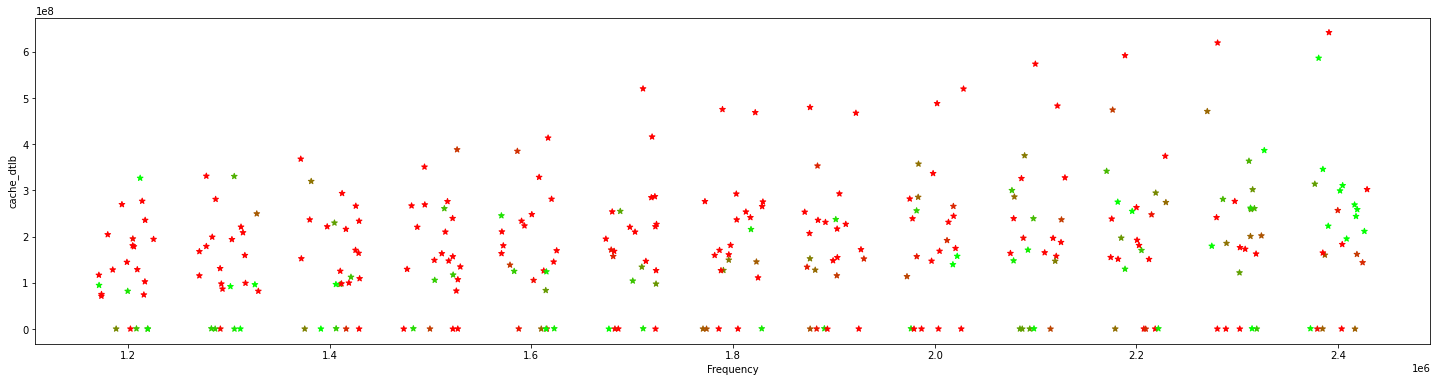

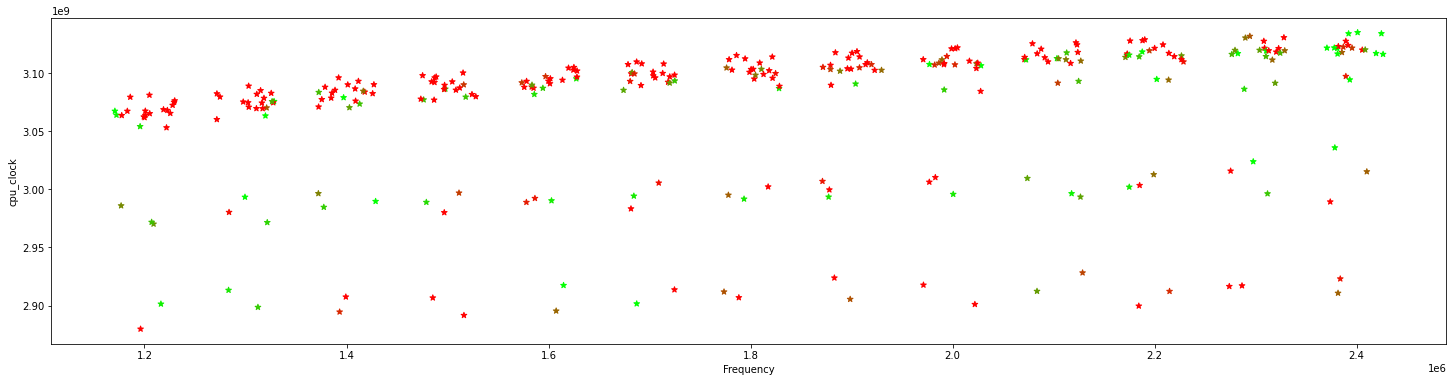

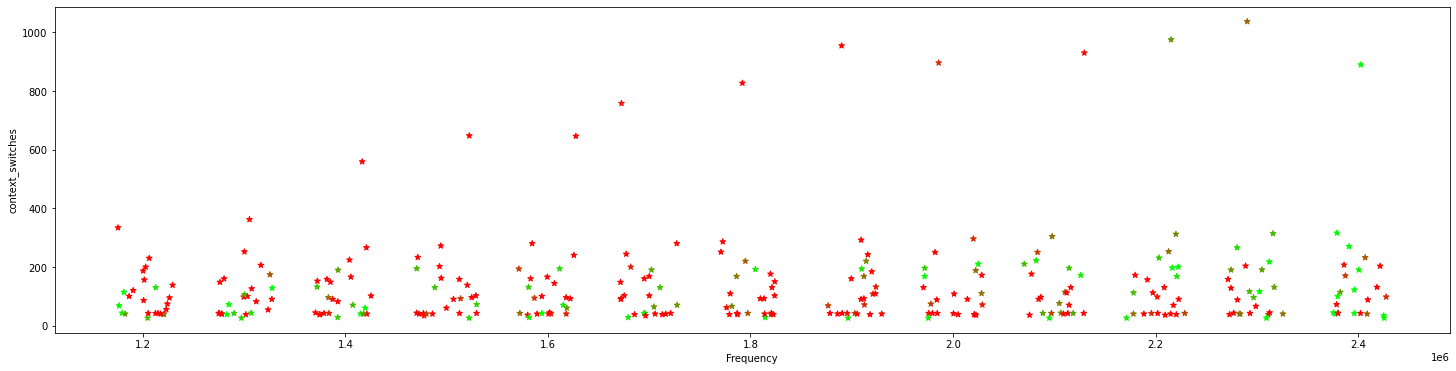

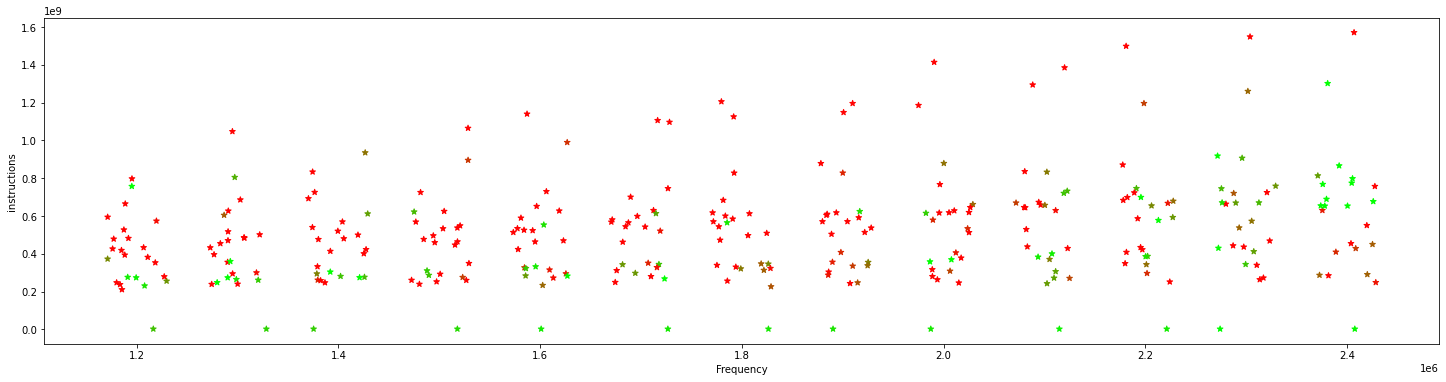

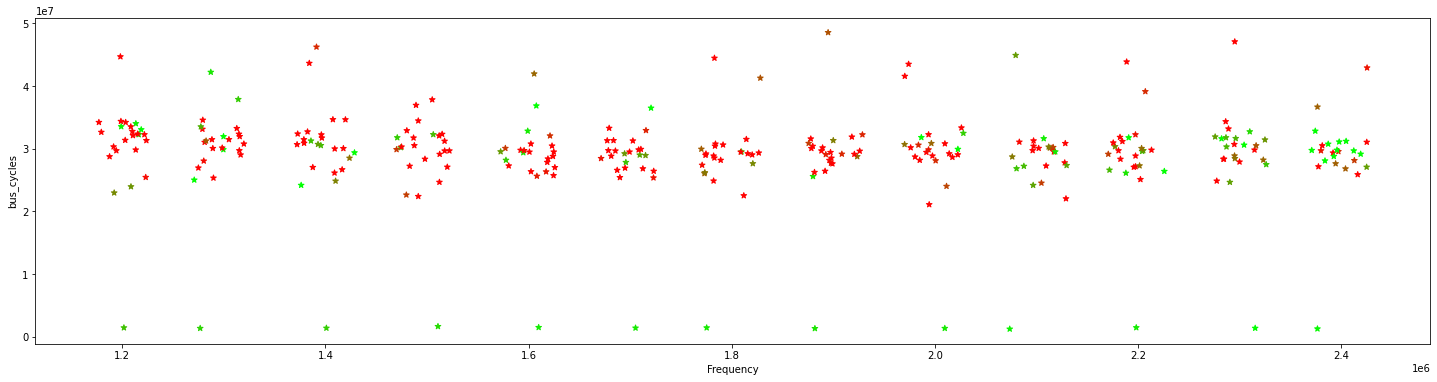

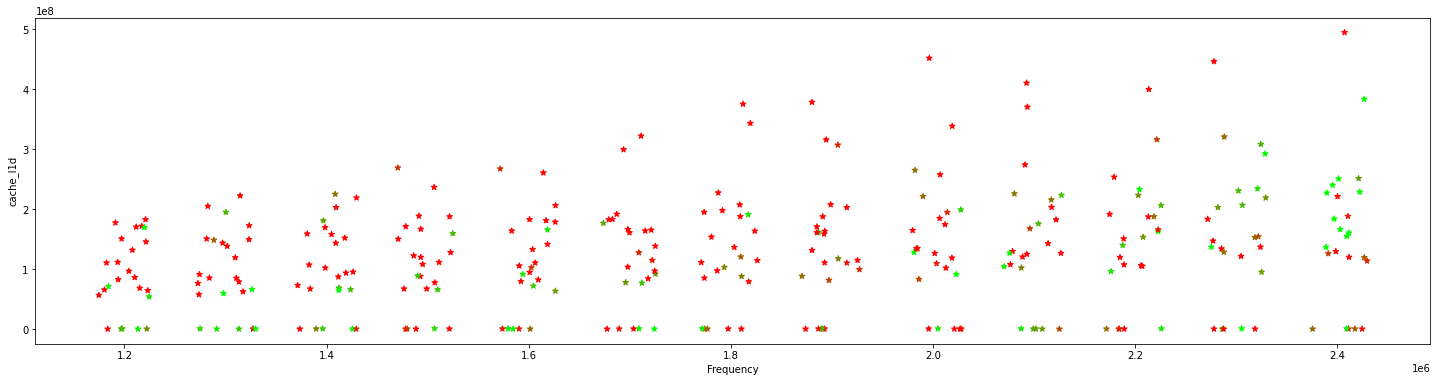

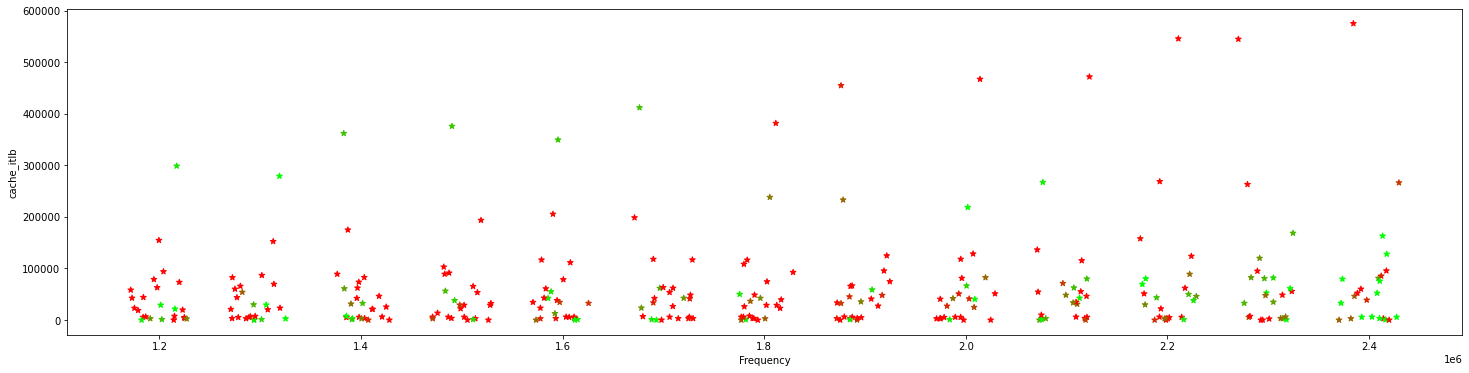

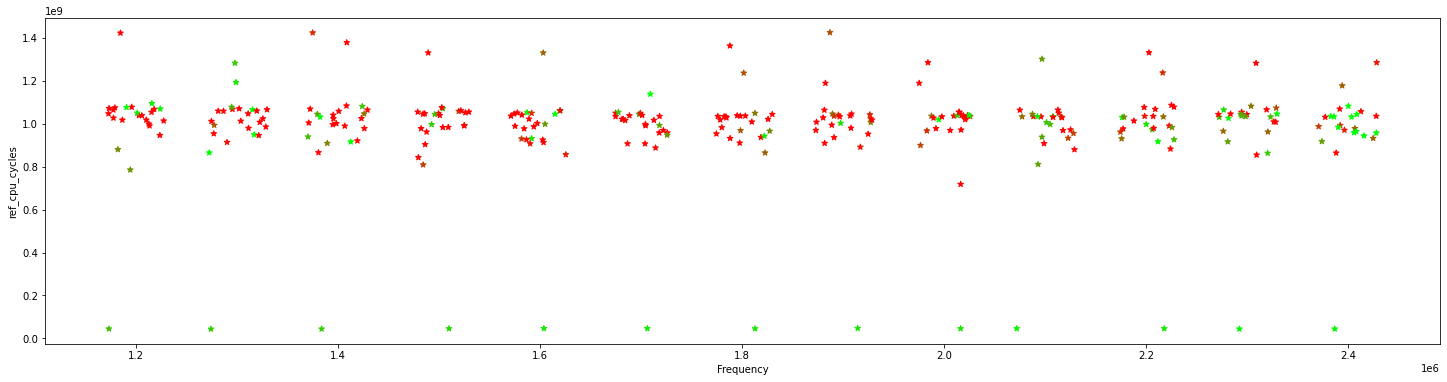

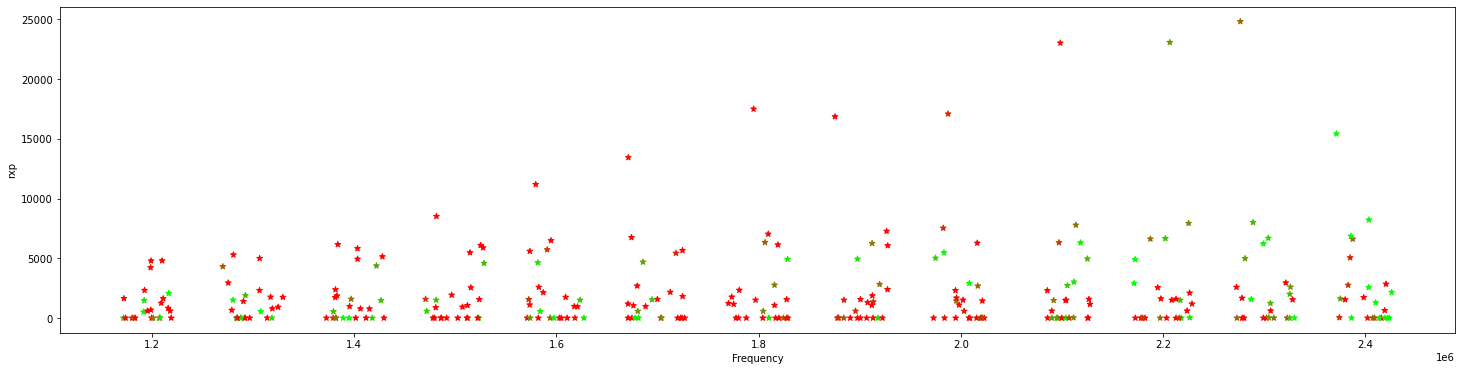

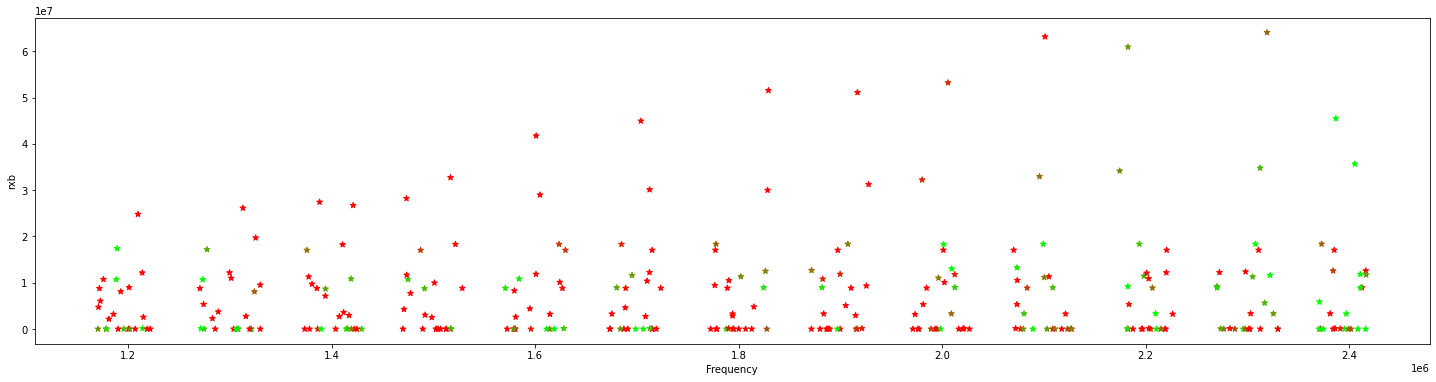

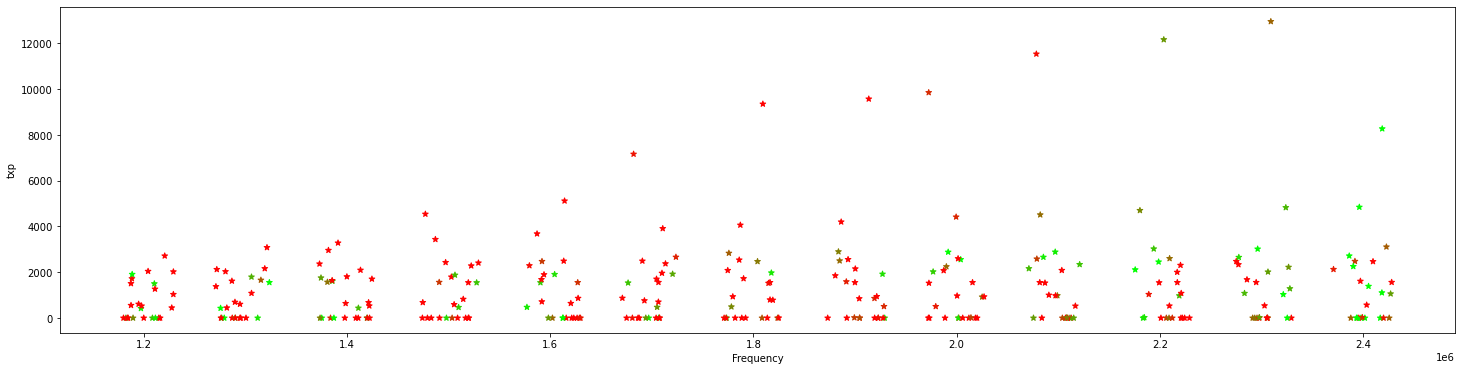

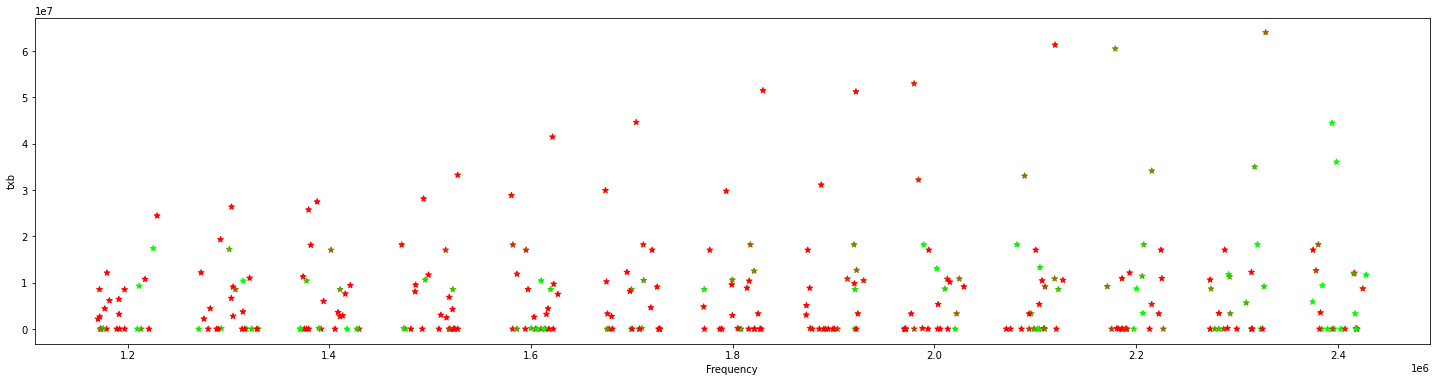

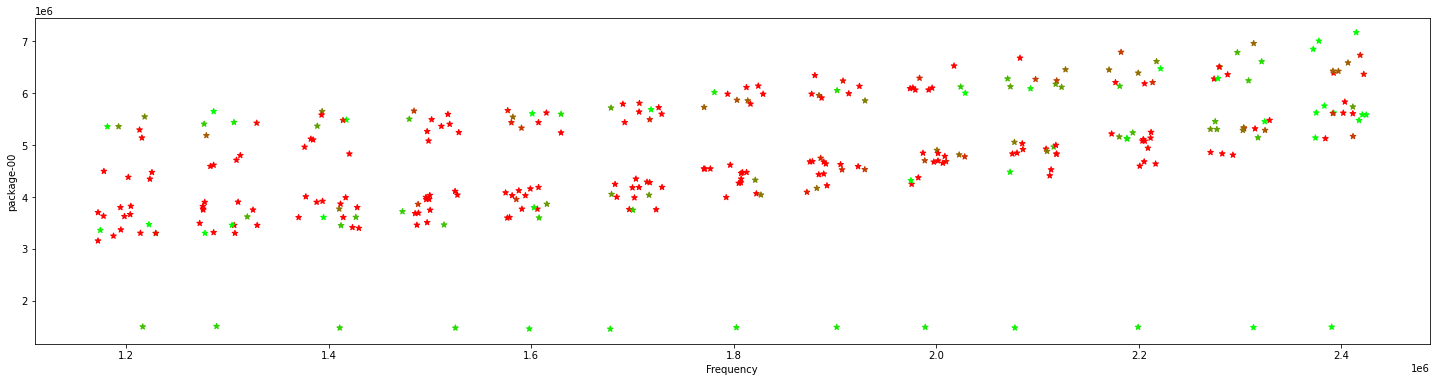

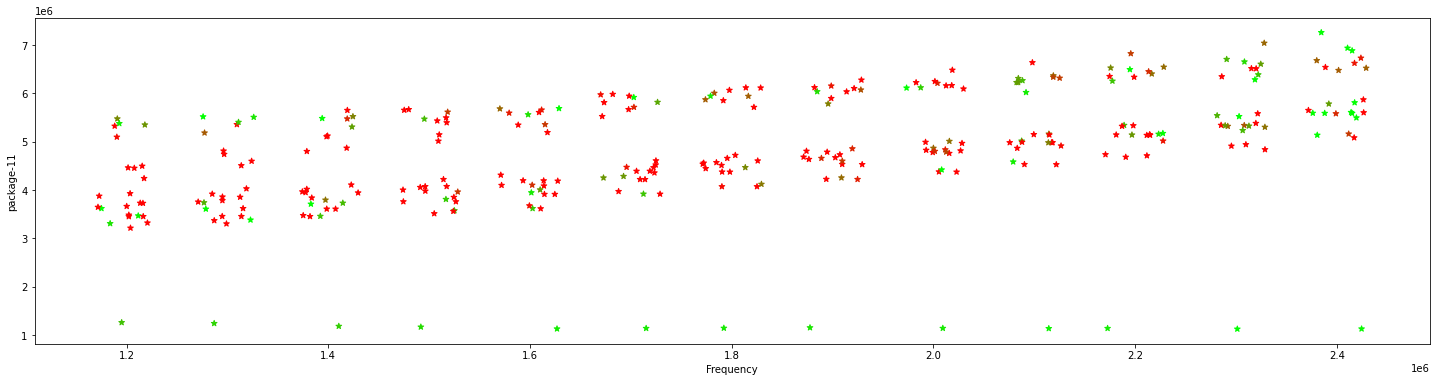

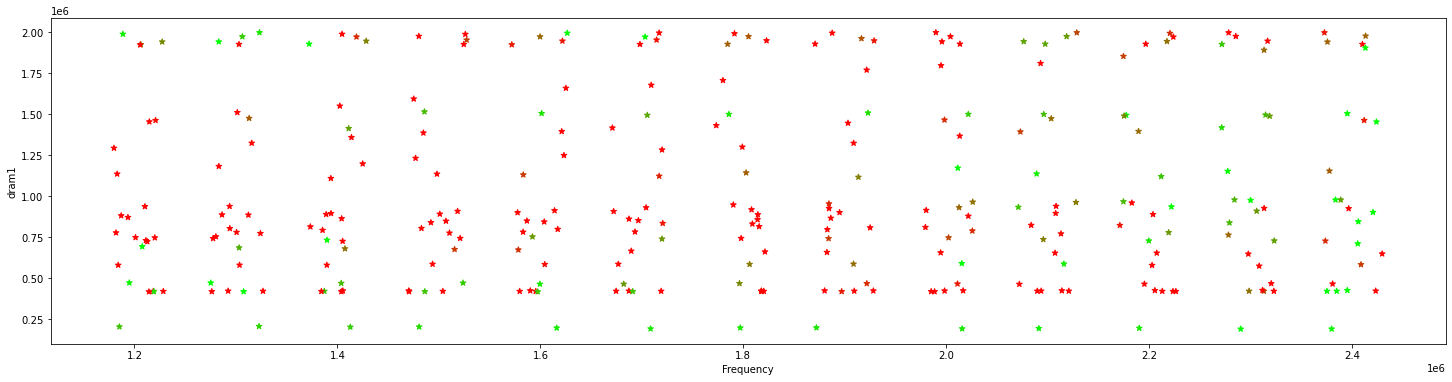

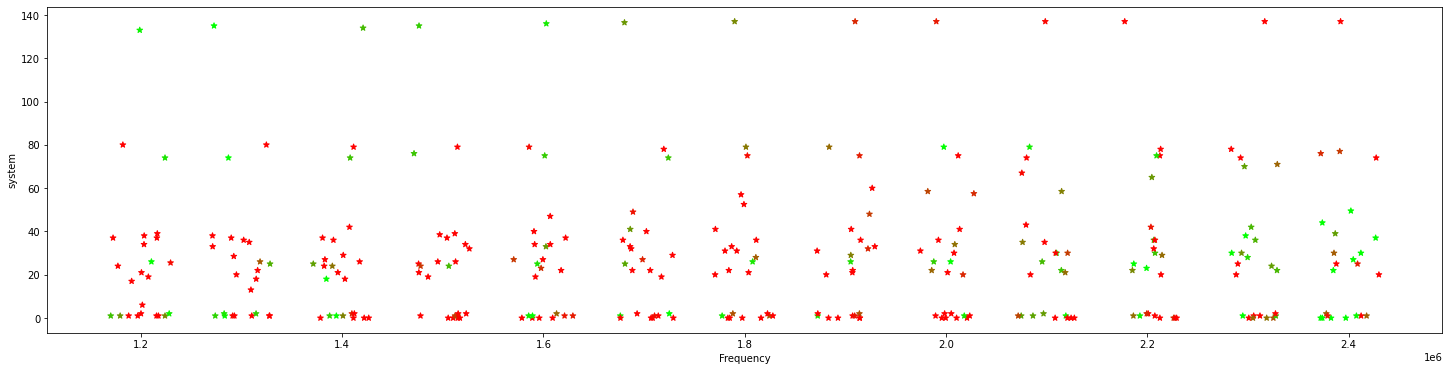

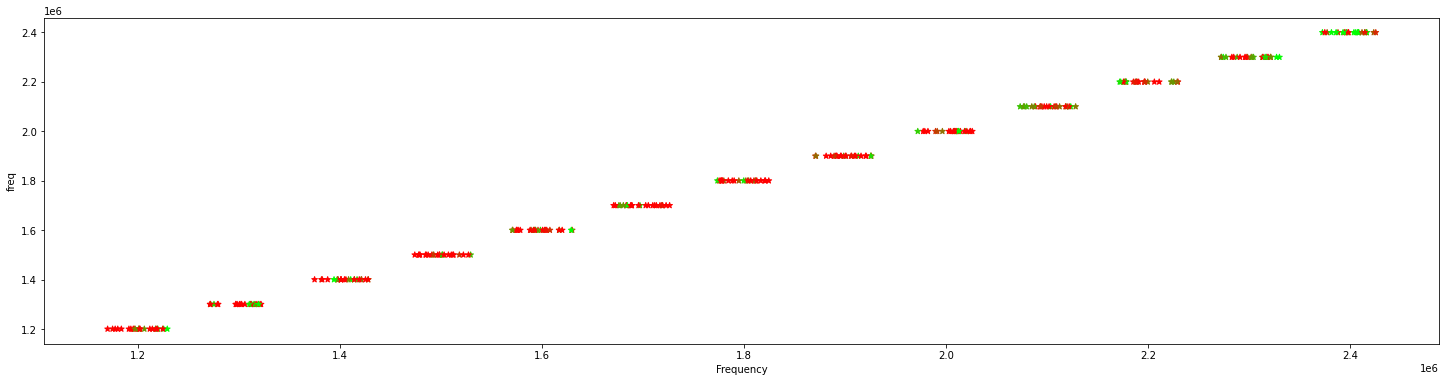

In [39]:
metric_name = 'etp_rel'
percentage_limit = 10

metric = [colormap(row[metric_name]/min(knowledge[(knowledge.fullname==row.fullname) & (knowledge.hostname==row.hostname) ][metric_name])-1, percentage_limit) 
          for _,row in knowledge.iterrows()]

#for hw_pct in vectors_prunned:
for hw_pct in vectors_prunned:
    show_graph(hw_pct, vectors[hw_pct], metric, knowledge.fmax)

In [41]:
def colormap(val, percentage_limit):
    ratio = 100/percentage_limit
    red = min(1, max(0, ratio*val))
    return (red, 1-red, 0)

def show_graph(name, vect, colors, frequencies, spread=30000):
    f=plt.figure(figsize=(25,6))
    plt.ylabel(name)
    plt.xlabel("Frequency")
    plt.scatter([freq+random.randint(-spread,spread) for freq in frequencies], 
                vect,
                c= colors, marker='*')
    
    
metric_name = 'etp_rel'
percentage_limit = 10

metric = [colormap(row[metric_name]/min(knowledge[(knowledge.fullname==row.fullname) & (knowledge.hostname==row.hostname) ][metric_name])-1, percentage_limit) 
          for _,row in knowledge.iterrows()]

#for hw_pct in vectors_prunned:
for hw_pct in ['dram0']:
    show_graph(hw_pct, vectors[hw_pct], metric, knowledge.fmax)
    
    
#TODO: Remove scaling as "etp_rel" is already scalled
#TODO Add a filter "knowledge.etp_rel <= 1.05"

In [42]:
def get_corr(knowledge, vectors, vectors_col, freq, metric):
    a=vectors[vectors_col][knowledge.fmax == freq]
    b=knowledge[knowledge.fmax == freq][metric]
    return a.corr(b)

In [43]:
get_corr(knowledge, vectors_prunned, 'dram0', 1200000,  'etp')

0.05774490248021371

In [44]:
pd.DataFrame([[feature, abs(get_corr(knowledge, vectors_prunned, feature, 1200000,  'etp_rel'))] for feature in vectors_prunned]).sort_values(by=1, ascending=False)

0         1
4             cpu_clock  0.497005
28                dram1  0.362139
26                dram0  0.351220
10            cache_l1d  0.315437
7          instructions  0.306142
17        branch_misses  0.303765
11        cache_op_read  0.301512
2            cache_dtlb  0.298716
0        cpu_migrations  0.264725
3   cache_result_access  0.252967
25           package-00  0.247144
8            bus_cycles  0.244372
30               system  0.233033
27           package-11  0.219339
1          cache_misses  0.214801
22                  rxb  0.210630
24                  txb  0.206117
13          page_faults  0.192890
23                  txp  0.191228
21                  rxp  0.184257
6      context_switches  0.175860
20       ref_cpu_cycles  0.174655
16     cache_references  0.126814
32              softirq  0.119697
19           cache_itlb  0.115276
31                 idle  0.107105
15            cache_bpu  0.106589
9   branch_instructions  0.084604
29                 user  0.065542
14           cache_node  0.051249
5            cpu_cycles  0.040565
12    cache_op_prefetch  0.021709
18             cache_ll  0.019638
33                 freq       NaN

In [45]:
feature = 'instructions'

a=pd.DataFrame([[freq, abs(get_corr(knowledge, vectors_prunned, feature, freq,  'etp_rel'))] for freq in set(knowledge.fmax)]).sort_values(by=0)
print (a.sum()[1])
a


4.282580197954199


0         1
0   1200000  0.306142
2   1300000  0.341766
4   1400000  0.355116
3   1500000  0.408170
1   1600000  0.411419
5   1700000  0.398558
6   1800000  0.397918
7   1900000  0.358552
8   2000000  0.364289
9   2100000  0.587502
11  2200000  0.178070
10  2300000  0.163417
12  2400000  0.011663

In [46]:
feature = 'instructions'
pd.DataFrame([ (feature, max([ abs(get_corr(knowledge, vectors_prunned, feature, freq,  'etp_rel')) for freq in set(knowledge.fmax)]))
    for feature in vectors_prunned]).sort_values(by=1, ascending=False)

0         1
9   branch_instructions  0.654470
15            cache_bpu  0.642218
7          instructions  0.587502
3   cache_result_access  0.528301
4             cpu_clock  0.512655
2            cache_dtlb  0.509582
11        cache_op_read  0.501904
10            cache_l1d  0.494622
1          cache_misses  0.464909
16     cache_references  0.413334
29                 user  0.382546
20       ref_cpu_cycles  0.380368
12    cache_op_prefetch  0.377356
30               system  0.376462
18             cache_ll  0.375073
17        branch_misses  0.369724
28                dram1  0.362139
5            cpu_cycles  0.353515
26                dram0  0.351220
21                  rxp  0.349049
14           cache_node  0.346280
22                  rxb  0.344760
24                  txb  0.341342
19           cache_itlb  0.340744
23                  txp  0.338926
32              softirq  0.329184
13          page_faults  0.305535
6      context_switches  0.300345
8            bus_cycles  0.297477
0        cpu_migrations  0.281548
31                 idle  0.279580
25           package-00  0.247144
27           package-11  0.219339
33                 freq       NaN